In [1]:
import sys
sys.path.append('../Util')

In [2]:
from evaluation import aabcc, sig_props, correlation, lr, perceptron, kmeans_1dim, \
                     score_comparison, run_tests, report, dimensions_report, repeated_dimensions, \
                    kmeans_multi_dim
from preparation import prepare_dataset, read_datasets

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import seaborn as sns

In [4]:
models = [
    {
        'name': 'flaubert/flaubert_small_cased',
        'label': 'flau_small_c'
    },
    {
    
        'name': 'flaubert/flaubert_base_uncased', 
        'label': 'flau_base_u'

    },
    {
        'name': 'flaubert/flaubert_base_cased',
        'label': 'flau_base_c'
    },
    {
        'name': 'flaubert/flaubert_large_cased',
        'label': 'flau_large_c'
    },
    {
        'name': 'camembert/camembert-base',
        'label': 'cam_base'
    }
    
]

In [5]:
labels = [m['label'] for m in models]

# Nouns

In [6]:
we_with_features = read_datasets(
                            path = '../Data',
                            model_labels = labels,
                            file_name = 'all_unique_pos_we.csv'
                    )

In [7]:
we_with_features[0].head()

,0,1,2,3,4,5,6,7,8,9,...,508,509,510,511,Number,Gender,Lemma,POS,Tense,Person
Word,,,,,,,,,,,,,,,,,,,,,
2D,5.531172,-8.963815,1.558320,3.143550,-5.372142,-0.174002,-1.124767,5.729996,-2.367389,4.247167,...,-2.374313,-7.161043,2.704918,-4.613951,invariable,feminine,2D,NOUN,NaN,NaN
3D,3.969331,-6.442656,1.451928,3.447791,-4.224664,-1.029557,-3.664733,4.911453,0.223902,5.621365,...,-1.463473,-10.008975,2.005870,-2.951385,invariable,feminine,3D,NOUN,NaN,NaN
aa,5.617864,-6.741737,2.519838,-3.914263,2.801907,-1.182259,4.435670,-1.600746,-0.582458,1.409745,...,-0.108588,0.809533,-10.274058,2.984729,invariable,masculine,aa,NOUN,NaN,NaN
aba,4.914313,-6.923126,-3.848757,5.110574,-2.516107,-4.938292,2.373581,-2.756590,2.567556,2.412183,...,-0.979258,-2.605051,-7.204095,-4.154819,singular,masculine,aba,NOUN,NaN,NaN
abaisse,4.652038,-4.028066,0.883200,4.782077,-2.294614,-3.894452,-0.810279,-0.713935,4.819910,4.090150,...,-7.542219,-4.662947,-0.546076,-1.836028,singular,feminine,abaisse,NOUN,NaN,NaN


For all WE, the last 6 columns contain word information (`Number`, `Gender`, `Lemma`, `POS`, `Tense`, `Person`) and all the other columns correspond to WE dimension values.

For the data preparation we will do the following:
- Take only nouns
- For each WE we will take all the columns except the last 7 (word info values) and normalize them.
- We will as well get a `Gender` vector for each WE for all consequent tests.

In [8]:
feature_col_count = 6
feature = 'Gender'

In [9]:
we_with_features[0][we_with_features[0].POS == 'NOUN']['Gender'].unique()

array(['feminine', 'masculine', 'invariable'], dtype=object)

We can also see that `Gender` can contain `invariable` values, since our tests are tailored to be binary, we will exclude these words from datasets prior to normalization.

In [10]:
normalized_dims = []
feature_vectors = []

In [11]:
for we in we_with_features:
    we = we[we.POS == 'NOUN']
    we_binary = we[we.Gender != 'invariable']
    dims, f_vec = prepare_dataset(we_binary, feature_col_count=feature_col_count, feature_name=feature)
    normalized_dims.append(dims)
    feature_vectors.append(f_vec)

Now we will run our 6 tests (aabcc, sig-props, correlation, logistic regression weights, perceptron weights, Kmeans clustering on one dimension) for each of the models.

In [12]:
tests = [
    aabcc,
    sig_props,
    correlation,
    lr,
    perceptron,
    kmeans_1dim
]

In [13]:
all_res = run_tests(tests, normalized_dims, feature_vectors, labels, report_progress=True)

Currently running: AABCC
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: SIG_PROPS
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: CORRELATION
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: LR
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: PERCEPTRON
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: KMEANS_1DIM
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done


Now we can compare the distribution of test results for each test and each model:

In [14]:
report_df = report(all_res, tests, labels)
report_df

,Min,Max,Mean,25%,50%,75%,95%,97.7%,99.9%
AABCC_flau_small_c,17048,19819,17810.906250,17575.750000,17757.500000,17997.000000,18349.400000,18778.729000,19729.575000
AABCC_flau_base_u,21445,22931,22194.013021,22029.250000,22187.500000,22370.000000,22631.650000,22739.359000,22927.165000
AABCC_flau_base_c,16881,18401,17653.996094,17492.500000,17647.000000,17813.750000,18080.650000,18176.795000,18394.097000
AABCC_flau_large_c,17064,22439,17979.069336,17628.750000,17851.000000,18140.000000,18993.350000,19638.355000,21611.158000
AABCC_cam_base,11334,12430,11881.050781,11747.750000,11881.000000,12007.000000,12206.650000,12296.077000,12428.466000
SIG_PROPS_flau_small_c,0.0,0.071085,0.014011,0.005745,0.012077,0.020360,0.032297,0.040204,0.064729
SIG_PROPS_flau_base_u,0.00002,0.021947,0.005139,0.001901,0.004240,0.007316,0.012924,0.015308,0.020697
SIG_PROPS_flau_base_c,0.000018,0.033774,0.007142,0.002908,0.005894,0.010189,0.017559,0.019885,0.031268
SIG_PROPS_flau_large_c,0.000015,0.078937,0.019347,0.007884,0.016551,0.028152,0.046886,0.056370,0.077988
SIG_PROPS_cam_base,0.000021,0.033523,0.007032,0.002747,0.006030,0.010248,0.016982,0.019512,0.032153


We can notice that for all tests we see the highest results for FlauBERT small, potentially due to the size of the embedding (512 dimensions vs 768 for FlauBERT and CamemBERT base vs 1024 for FlauBERT large). We can hypothesize that this is due to information being spread in more dimensions in larger models.

We can also observe that CamemBERT WE embeddings get poorer results, as we saw before, the CamemBERT embeddings recognize less words and potentially operate with stems (eg. `mangeons` is tokenized as `mange` and `ons`).

We can plot the distributions for each test now:

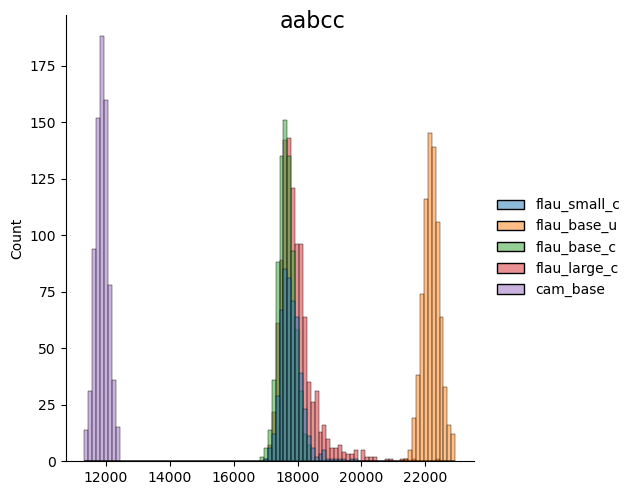

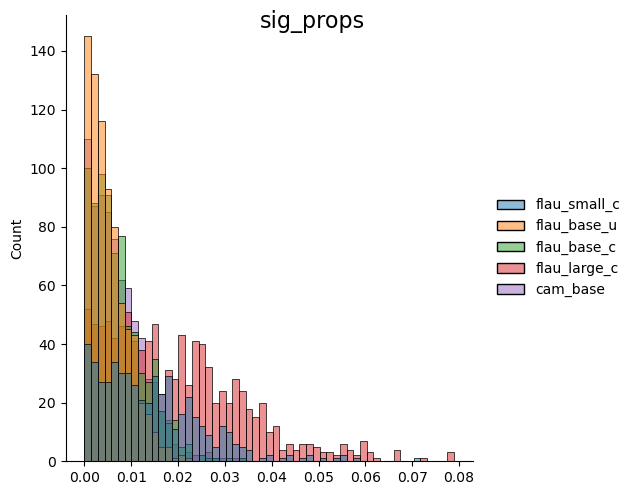

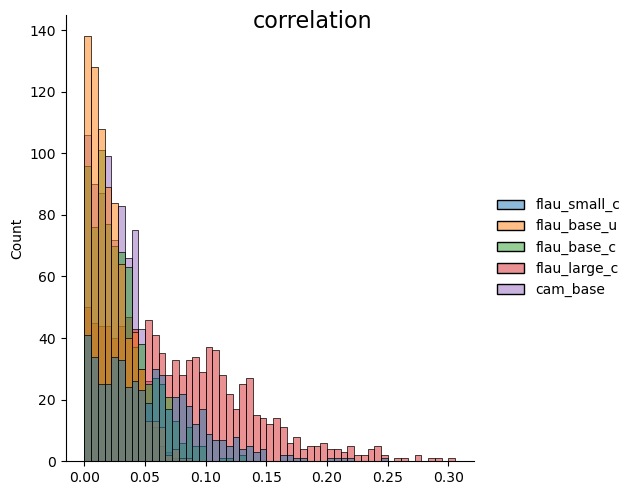

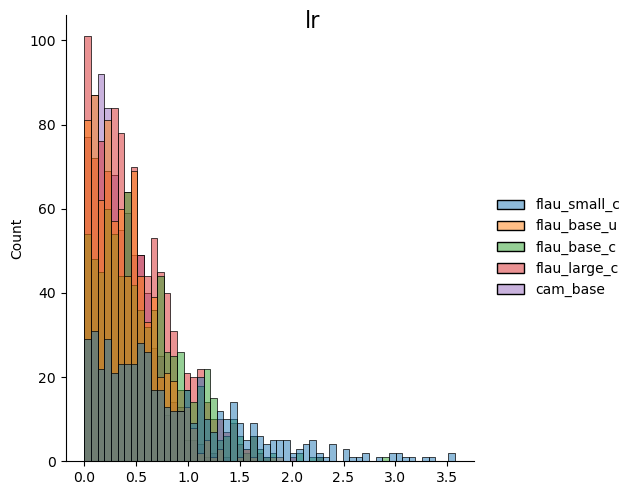

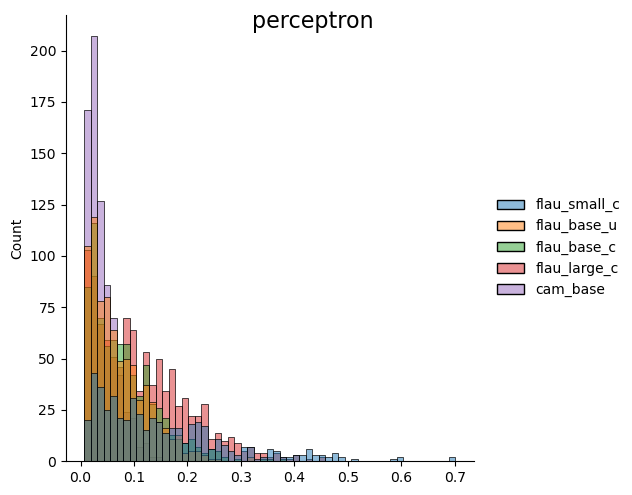

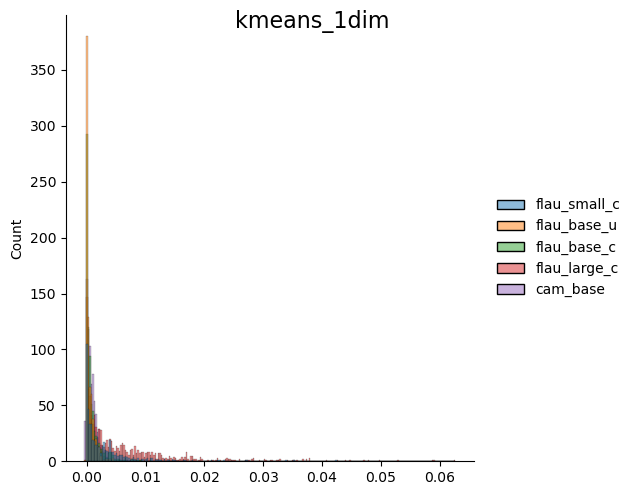

In [15]:
for i in range(len(tests)):
    temp_df = pd.DataFrame(list(map(lambda y: list(map(lambda x: x[1], y)), all_res[i])), index=labels)
    g = sns.displot(temp_df.T)
    g.fig.suptitle(tests[i].__name__, fontsize=16)


From the graphs, the distribution for AABCC results appears normal, however, the other tests have very big skew to the left.

First, just to verify we will test the distribution of AABCC results of each model for normality. We will use Shapiro test for normality that will test the null-hypothesis that the distribution is normal. 

In [16]:
list(map(lambda z: shapiro(np.log(z)), (map(lambda y: list(map(lambda x: x[1], y)), all_res[0]))))

[ShapiroResult(statistic=0.9209180474281311, pvalue=9.564674864571878e-16),
 ShapiroResult(statistic=0.998201310634613, pvalue=0.6099777817726135),
 ShapiroResult(statistic=0.9974977374076843, pvalue=0.29828885197639465),
 ShapiroResult(statistic=0.8303964138031006, pvalue=1.354300559767392e-31),
 ShapiroResult(statistic=0.9981833696365356, pvalue=0.6006255745887756)]

We can see that AABCC results distribution is not normal for FlauBERT small and large. Making most of result distributions non-normal. 

Since we can't assume normality of the data to find the dimensions with the highest scores, we suggest looking at 99 percentile.

In [17]:
percentile = 99

In [18]:
dimensions_df = dimensions_report(all_res, tests, labels, percentile)
dimensions_df

,flau_small_c,flau_base_u,flau_base_c,flau_large_c,cam_base
AABCC,"[100, 403, 316, 306, 117, 434]","[273, 27, 220, 497, 29, 322, 452, 21, 551]","[113, 698, 589, 749, 459, 206, 526, 277]","[136, 182, 1022, 88, 972, 575, 743, 292, 725, ...","[141, 96, 550, 282, 95, 195, 766, 672]"
SIG_PROPS,"[100, 195, 117, 316, 403, 202]","[21, 185, 644, 244, 263, 382, 138, 81]","[526, 749, 117, 83, 157, 209, 500, 187]","[972, 182, 136, 1022, 311, 575, 342, 639, 292,...","[100, 173, 272, 119, 309, 401, 579, 244]"
CORRELATION,"[100, 195, 403, 316, 117, 306]","[21, 263, 244, 644, 138, 185, 81, 382]","[209, 526, 493, 749, 494, 83, 157, 337]","[136, 972, 182, 639, 1022, 575, 743, 311, 725,...","[270, 244, 243, 173, 401, 78, 376, 147]"
LR,"[162, 434, 265, 100, 468, 198]","[752, 159, 21, 644, 323, 563, 127, 735]","[587, 643, 359, 283, 175, 274, 752, 135]","[560, 994, 354, 15, 897, 771, 326, 793, 902, 1...","[244, 759, 522, 420, 162, 313, 274, 312]"
PERCEPTRON,"[100, 434, 316, 507, 117, 499]","[382, 21, 185, 81, 138, 456, 546, 594]","[749, 526, 209, 70, 216, 513, 359, 71]","[136, 972, 182, 1022, 575, 795, 743, 274, 1016...","[173, 243, 244, 558, 628, 98, 384, 474]"
KMEANS_1DIM,"[100, 403, 195, 117, 316, 202]","[244, 206, 644, 480, 138, 185, 149, 516]","[526, 337, 209, 7, 493, 749, 500, 544]","[136, 972, 182, 639, 1022, 725, 575, 806, 743,...","[270, 628, 376, 328, 147, 184, 41, 7]"


In the table above we can see the dimensions having values more or equal than 99 percentile for each result distribution.

Now we can have a look at the repeated dimensions. The table below contains:
- All unique dimensions observed in 99 percentile during 6 tests for each model
- Dimensions that appeared in 1 or more/2 or more/3 or more/4 or more/5 or more/6 tests
- Dimensions that appeared in 50% of tests (3 or more tests) in 99 percentile

In [19]:
repeated_dimensions_df = repeated_dimensions(dimensions_df, labels)

In [20]:
repeated_dimensions_df

,1 test,2 tests,3 tests,4 tests,5 tests,6 tests
flau_small_c,"[100, 117, 162, 195, 198, 202, 265, 306, 316, ...","[100, 117, 195, 202, 306, 316, 403, 434]","[100, 117, 195, 316, 403, 434]","[100, 117, 316, 403]","[100, 117, 316]",[100]
flau_base_u,"[21, 27, 29, 81, 127, 138, 149, 159, 185, 206,...","[21, 81, 138, 185, 244, 263, 382, 644]","[21, 81, 138, 185, 244, 382, 644]","[21, 138, 185, 644]",[21],[]
flau_base_c,"[7, 70, 71, 83, 113, 117, 135, 157, 175, 187, ...","[83, 157, 209, 337, 359, 493, 500, 526, 749]","[209, 526, 749]","[209, 526, 749]","[526, 749]",[]
flau_large_c,"[15, 56, 88, 136, 182, 274, 284, 292, 311, 326...","[136, 182, 292, 311, 342, 464, 575, 639, 725, ...","[136, 182, 311, 342, 575, 639, 725, 743, 972, ...","[136, 182, 342, 575, 743, 972, 1022]","[136, 182, 575, 743, 972, 1022]",[]
cam_base,"[7, 41, 78, 95, 96, 98, 100, 119, 141, 147, 16...","[147, 173, 243, 244, 270, 376, 401, 628]","[173, 244]",[244],[],[]


In [21]:
ari_scores_df = pd.DataFrame(columns = ['All_dims', '1_dim_best', 
                                        '1_test_dims', '2_test_dims',
                                        '3_test_dims', '4_test_dims',
                                        '5_test_dims', '6_test_dims'
                                       ])

In [22]:
for i in range(len(labels)):
    model = labels[i]
    n_dims = len(all_res[0][i])
    ari_scores_df.loc[model] = {
        'All_dims' : kmeans_multi_dim(normalized_dims[i], list(range(n_dims)), feature_vectors[i]), 
        '1_dim_best': all_res[-1][i][0][1], 
        '1_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_df.loc[model]['1 test'], feature_vectors[i]), 
        '2_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_df.loc[model]['2 tests'], feature_vectors[i]),
        '3_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_df.loc[model]['3 tests'], feature_vectors[i]),
        '4_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_df.loc[model]['4 tests'], feature_vectors[i]),
        '5_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_df.loc[model]['5 tests'], feature_vectors[i]),
        '6_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_df.loc[model]['6 tests'], feature_vectors[i]),
    }

In [23]:
ari_scores_df

,All_dims,1_dim_best,1_test_dims,2_test_dims,3_test_dims,4_test_dims,5_test_dims,6_test_dims
flau_small_c,0.017239,0.042418,0.097279,0.100134,0.115805,0.096995,0.074545,0.042418
flau_base_u,-0.000234,0.004609,-0.000057,0.000913,0.003597,0.004333,0.002672,NaN
flau_base_c,-0.000112,0.010896,-0.000113,0.000986,0.001690,0.001690,0.003059,NaN
flau_large_c,-0.000081,0.062649,0.432549,0.327233,0.279955,0.257351,0.257121,NaN
cam_base,0.001259,0.006974,0.001259,0.001530,0.001918,0.003522,NaN,NaN


In the DataFrame above you will find ARI scores for each model for clustering nouns into 2 gender clusters.
- `All_dims` represents ARI for clustering using all dimensions of WE
- `1_dim_best` shows ARI for one dimension that had the best ARI score
- `1/2/3/4/5/6_test_dims` shows ARI scores for clustering on dimensions that were repeatedly seen in _at least_ 1/2/3/4/5/6 test results.

We can see that for all models clustering becomes better when using test result dimensions or one dimension only in comparison to all of the dimensions.

However, for FlauBERT base cased model, clustering on one dimension only shows the best results which can be potentially a sign that the nouns gender information got encoded in one dimension only. Nevertheless, it's worth noting that all ARI scores stay relatively low.

We can see more than 2-times improvement in ARI scores for FlauBERT small when using dimensions that appeared in at least 3 test results. For FlauBERT large this improvement is even bigger with more than 4-times improvement. However, it's worth noting that when using dimensions that appeared in just one test result we see even better results with 7-times improvement in comparison to one dimension.
This could be a sign that 99 percentile is not the most optimal selection method.

_________

# Adjectives

We can now repeat the experiment for Adjectives.

In [24]:
normalized_dims = []
feature_vectors = []

In [25]:
for we in we_with_features:
    we = we[we.POS == 'ADJ']
    we_binary = we[we.Gender != 'invariable']
    dims, f_vec = prepare_dataset(we_binary, feature_col_count=feature_col_count, feature_name=feature)
    normalized_dims.append(dims)
    feature_vectors.append(f_vec)

In [26]:
all_res_adj = run_tests(tests, normalized_dims, feature_vectors, labels, report_progress=True)

Currently running: AABCC
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: SIG_PROPS
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: CORRELATION
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: LR
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: PERCEPTRON
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done
Currently running: KMEANS_1DIM
		Model: flau_small_c
		Model: flau_base_u
		Model: flau_base_c
		Model: flau_large_c
		Model: cam_base
Done


In [27]:
report_adj_df = report(all_res_adj, tests, labels)
report_adj_df

,Min,Max,Mean,25%,50%,75%,95%,97.7%,99.9%
AABCC_flau_small_c,4750,8787,5450.464844,5223.750000,5363.500000,5581.000000,6163.450000,6548.621000,8232.565000
AABCC_flau_base_u,5989,8163,6653.114583,6429.500000,6615.000000,6826.500000,7222.300000,7344.000000,8025.707000
AABCC_flau_base_c,4781,6161,5302.333333,5154.250000,5292.000000,5429.000000,5655.000000,5727.744000,6124.184000
AABCC_flau_large_c,4791,11110,5521.178711,5238.750000,5425.500000,5671.750000,6287.000000,6665.123000,9557.110000
AABCC_cam_base,2246,3039,2578.128906,2497.750000,2572.000000,2643.250000,2779.600000,2834.231000,3030.563000
SIG_PROPS_flau_small_c,0.000197,0.124799,0.027489,0.010330,0.023679,0.039371,0.066931,0.078032,0.109201
SIG_PROPS_flau_base_u,0.000031,0.044771,0.010119,0.003932,0.009104,0.014344,0.023661,0.028426,0.039779
SIG_PROPS_flau_base_c,0.000001,0.048622,0.012550,0.004936,0.010435,0.018294,0.030785,0.035297,0.047499
SIG_PROPS_flau_large_c,0.000119,0.131492,0.029026,0.010993,0.024982,0.042876,0.068484,0.081811,0.103145
SIG_PROPS_cam_base,0.000042,0.126744,0.027955,0.011013,0.022972,0.040854,0.069446,0.081659,0.125623


In [28]:
dimensions_adj_df = dimensions_report(all_res_adj, tests, labels, percentile)
dimensions_adj_df

,flau_small_c,flau_base_u,flau_base_c,flau_large_c,cam_base
AABCC,"[466, 432, 245, 114, 57, 471]","[618, 201, 283, 361, 759, 198, 721, 278]","[611, 325, 331, 329, 653, 528, 418, 648]","[795, 182, 251, 507, 136, 998, 862, 165, 869, ...","[209, 248, 231, 560, 284, 372, 10, 567]"
SIG_PROPS,"[466, 57, 38, 300, 121, 471]","[153, 345, 626, 720, 405, 508, 298, 574]","[225, 331, 220, 484, 359, 304, 765, 421]","[795, 787, 132, 998, 251, 182, 165, 518, 972, ...","[100, 272, 714, 309, 467, 119, 430, 465]"
CORRELATION,"[466, 234, 57, 121, 38, 181]","[345, 143, 574, 285, 508, 541, 223, 171]","[331, 421, 337, 225, 601, 304, 526, 387]","[795, 972, 862, 182, 507, 165, 251, 787, 998, ...","[473, 258, 272, 465, 147, 713, 699, 401]"
LR,"[466, 250, 121, 260, 5, 195]","[571, 161, 672, 251, 357, 405, 597, 546]","[576, 189, 491, 359, 456, 298, 309, 698]","[169, 737, 1014, 972, 796, 1017, 585, 73, 256,...","[676, 238, 282, 443, 22, 141, 483, 234]"
PERCEPTRON,"[466, 245, 181, 88, 503, 38]","[508, 541, 285, 661, 345, 749, 510, 597]","[698, 526, 189, 337, 611, 70, 250, 77]","[795, 518, 165, 132, 393, 73, 182, 13, 708, 24...","[437, 699, 479, 141, 290, 20, 651, 400]"
KMEANS_1DIM,"[466, 57, 471, 234, 121, 293]","[345, 171, 702, 143, 624, 65, 652, 476]","[331, 304, 601, 662, 702, 674, 269, 399]","[795, 972, 897, 998, 760, 862, 132, 165, 411, ...","[49, 400, 663, 699, 286, 575, 709, 437]"


In [29]:
repeated_dimensions_adj_df = repeated_dimensions(dimensions_adj_df, labels)
repeated_dimensions_adj_df

,1 test,2 tests,3 tests,4 tests,5 tests,6 tests
flau_small_c,"[5, 38, 57, 88, 114, 121, 181, 195, 234, 245, ...","[38, 57, 121, 181, 234, 245, 466, 471]","[38, 57, 121, 466, 471]","[57, 121, 466]",[466],[466]
flau_base_u,"[65, 143, 153, 161, 171, 198, 201, 223, 251, 2...","[143, 171, 285, 345, 405, 508, 541, 574, 597]","[345, 508]",[345],[],[]
flau_base_c,"[70, 77, 189, 220, 225, 250, 269, 298, 304, 30...","[189, 225, 304, 331, 337, 359, 421, 526, 601, ...","[304, 331]",[331],[],[]
flau_large_c,"[13, 73, 118, 132, 136, 165, 169, 182, 241, 25...","[13, 73, 132, 136, 165, 182, 251, 507, 518, 78...","[132, 165, 182, 251, 518, 795, 862, 972, 998]","[132, 165, 182, 795, 972, 998]","[132, 165, 182, 795, 972]",[]
cam_base,"[10, 20, 22, 49, 100, 119, 141, 147, 209, 231,...","[141, 272, 400, 437, 465, 699]",[699],[],[],[]


In [30]:
ari_scores_adj_df = pd.DataFrame(columns = ['All_dims', '1_dim_best', 
                                        '1_test_dims', '2_test_dims',
                                        '3_test_dims', '4_test_dims',
                                        '5_test_dims', '6_test_dims'
                                       ])

In [31]:
for i in range(len(labels)):
    model = labels[i]
    n_dims = len(all_res[0][i])
    ari_scores_adj_df.loc[model] = {
        'All_dims' : kmeans_multi_dim(normalized_dims[i], list(range(n_dims)), feature_vectors[i]), 
        '1_dim_best': all_res_adj[-1][i][0][1], 
        '1_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_adj_df.loc[model]['1 test'], feature_vectors[i]), 
        '2_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_adj_df.loc[model]['2 tests'], feature_vectors[i]),
        '3_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_adj_df.loc[model]['3 tests'], feature_vectors[i]),
        '4_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_adj_df.loc[model]['4 tests'], feature_vectors[i]),
        '5_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_adj_df.loc[model]['5 tests'], feature_vectors[i]),
        '6_test_dims': kmeans_multi_dim(normalized_dims[i], repeated_dimensions_adj_df.loc[model]['6 tests'], feature_vectors[i]),
    }

In [32]:
ari_scores_adj_df

,All_dims,1_dim_best,1_test_dims,2_test_dims,3_test_dims,4_test_dims,5_test_dims,6_test_dims
flau_small_c,0.000293,0.081983,0.442108,0.278671,0.142449,0.121633,0.081983,0.081983
flau_base_u,-0.020144,0.042620,-0.019543,-0.019273,0.028021,0.042620,NaN,NaN
flau_base_c,0.007429,0.046228,0.013347,0.010498,0.058443,0.046228,NaN,NaN
flau_large_c,-0.011607,0.083925,0.489881,0.353876,0.335015,0.294675,0.256651,NaN
cam_base,0.005433,0.049542,0.005433,0.005524,0.045941,NaN,NaN,NaN
